In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib as plt
from matplotlib import pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (15,10)

In [2]:
print(cv2.__version__)

3.4.16-dev


In [3]:
# Questionnare Metadata
num_choices = 4
num_questions = 8

In [8]:
# Input Structure
img_dir = "./test_box/"
img_index = 0
img_file_name = []

entries = Path(img_dir)
for entry in entries.iterdir():
    img_file_name.append(entry.name)
    #print(entry.name)

In [9]:
img_file_name

['Photo on 12-5-21 at 17.38.jpg',
 'Photo on 12-5-21 at 17.39.jpg',
 'Photo on 12-5-21 at 17.40.jpg']

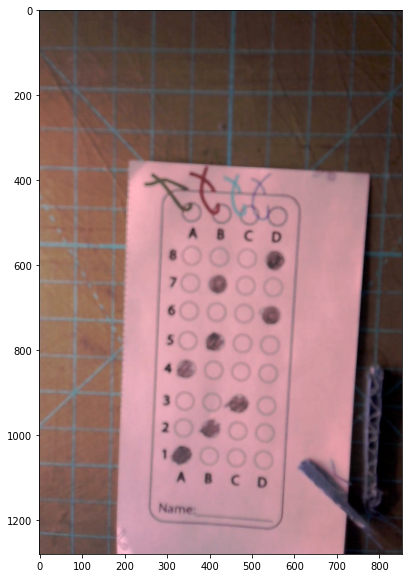

In [14]:
# load the image
#image = cv2.rotate(img_dir + img_file_name[img_index], cv2.ROTATE_90_CLOCKWISE)
image = cv2.imread(img_dir + img_file_name[img_index])

image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(image)

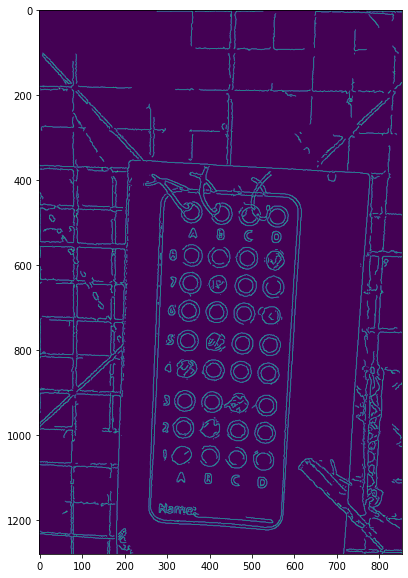

In [28]:
# grayscale, blur, edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 0, 35)
thresh = cv2.threshold(edged, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(edged)

1012


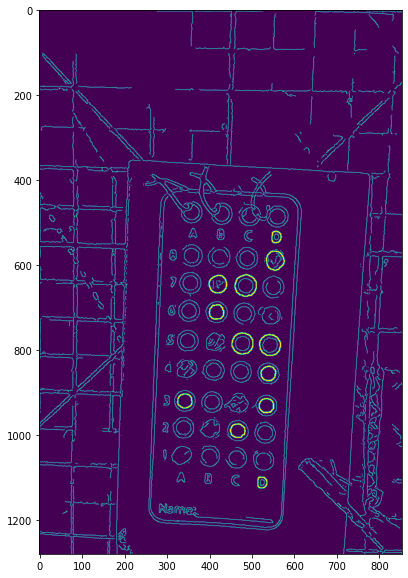

In [39]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
im2, contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

cnt = contours
#cv2.drawContours(image, cnt, 3, (0,255,0), 3)

circle_x = []
circle_y = []
questionCnts = []

image2 = edged.copy()
for c in contours:

    #---- making sure to avoid small unwanted contours ---
    if cv2.contourArea(c) > 100:
        epsilon = 0.03 * cv2.arcLength(c, True)
        approximations = cv2.approxPolyDP(c, epsilon, True)
        
        #--- selecting contours having more than 2 sides ---
        if  2 <= len(approximations):
            (x, y, w, h) = cv2.boundingRect(c)
            ar = w / float(h)
            
            # in order to label the contour as a question, region
            # should be sufficiently wide, sufficiently tall, and
            # have an aspect ratio approximately equal to 1
            if w >= 20 and h >= 20:
            #ar >= 0.85 and ar <= 1.15:
                questionCnts.append(c)
            
                #(x,y),radius = cv2.minEnclosingCircle(c)
                #x, y, w, h = cv2.boundingRect(c)
                #print(x, y)
            
            circle_x.append(x)
            circle_y.append(y)

cv2.drawContours(image2, questionCnts, -1, (255, 255, 255), 2)
plt.imshow(image2)

In [39]:
def sort_contours(cnts, method):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

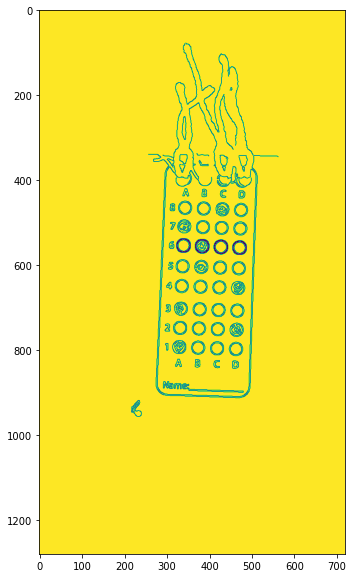

In [96]:
# Sort question circles from top to bottom 
questionCnts = sort_contours(questionCnts, "top-to-bottom")[0]

thresh_img = thresh.copy()
cv2.drawContours(thresh_img, questionCnts[8:12], -1, (0, 0, 0), 2)
plt.imshow(thresh_img)

(510, 2)
(510, 0)
(501, 1)
(538, 1)
(511, 3)
(521, 0)
(518, 3)
(521, 0)


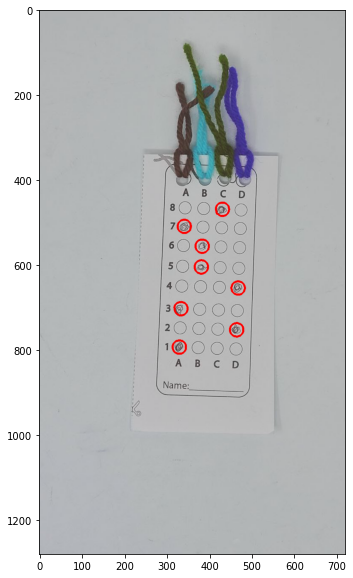

In [140]:
image3 = image.copy()

# Output Structure
circled_answer = []

for (q, i) in enumerate(np.arange(0, len(questionCnts), num_choices)):
    # sort the contours for the current question from
    # left to right, then initialize the index of the
    # bubbled answer
    cnts = sort_contours(questionCnts[i:i + num_choices], "left-to-right")[0]
    #print(cnts_tmp)
    bubbled = None
    
#     cv2.drawContours(image3, cnts, -1, 255, -1)
#     plt.imshow(image3)

    
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        #print("j: " + str(j))
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
    
        # apply the mask to the thresholded image, then
        # count the number of non-zero pixels in the
        # bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
        #print(total)
        
        # if the current total has a larger number of total
        # non-zero pixels, then we are examining the currently
        # bubbled-in answer
        if bubbled is None or total < bubbled[0]:
#             print("updated bubbled")
#             print(total)
#             print(j)
            
            bubbled = (total, j)
            #print(len(bubbled))
    print(bubbled)
    circled_answer.append(bubbled[1])
    cv2.drawContours(image3, [cnts[bubbled[1]]], -1, (255, 0, 0), 3)
    plt.imshow(image3)

In [141]:
print(circled_answer)

[2, 0, 1, 1, 3, 0, 3, 0]


In [61]:
bubbled

(638, 3)

# Draft

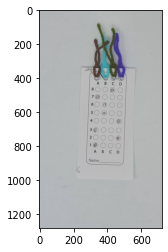

In [57]:
# im2, contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# #cnts = imutils.grab_contours(contours)
# docCnt = None
# # ensure that at least one contour was found
# if len(contours) > 0:
#     # sort the contours according to their size in
# 	# descending order
# 	cnts = sorted(contours, key=cv2.contourArea, reverse=True)
# 	# loop over the sorted contours
# 	for c in cnts:
# 		# approximate the contour
# 		peri = cv2.arcLength(c, True)
# 		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
# 		# if our approximated contour has four points,
# 		# then we can assume we have found the paper
# 		if len(approx) == 4:
# 			docCnt = approx
# 			break

# image3 = image.copy()
# cv2.drawContours(image3, docCnt, -1, (255, 0, 0), 2)
# plt.imshow(image3)

In [31]:
# apply a four point perspective transform to both the
# original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

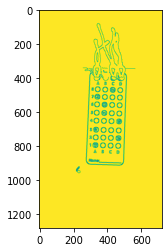

In [11]:
plt.imshow(thresh)